# Bringing in other factors: part I

!NOTE: this notebook uses an archived version of the library

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

In [5]:
__context__ = 'local'

import sys

if __context__ == 'local':
    trainDataLocation = '../data/train/'
    libraryLocation = '..'
    from public_timeseries_testing_util import MockApi
    env = MockApi()
    

elif __context__ == 'kaggle':
    trainDataLocation = '/kaggle/input/predict-energy-behavior-of-prosumers/'
    libraryLocation = '/kaggle/input/'
    import enefit
    env = enefit.make_env()

iter_test = env.iter_test()
sys.path.append(libraryLocation)


## Processing the other datasets


### Notes and ideas from processing:

1. historical weather is very useful for fitting the time-series baselines: we essentially want to remove the effect of weather when developing the time-dependent features.

2. Small improvement: double check the data  


In [6]:
weather_forecast = pd.read_csv(trainDataLocation+'forecast_weather.csv')
weather_historical = pd.read_csv(trainDataLocation+'historical_weather.csv')

weather_historical['datetime'] = pd.to_datetime(weather_historical['datetime'])
weather_historical = pl.from_pandas(weather_historical)

weather_forecast['origin_datetime'] = pd.to_datetime(weather_forecast['origin_datetime'])
weather_forecast['forecast_datetime'] = pd.to_datetime(weather_forecast['forecast_datetime'])
weather_forecast = pl.from_pandas(weather_forecast)

<Axes: xlabel='date'>

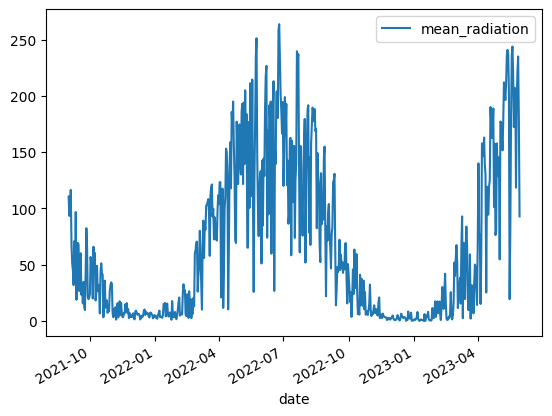

In [7]:
weather_historical.with_columns(
                    pl.col('datetime').dt.date().alias('date')
                 ).group_by('date'
                 ).agg(mean_radiation=pl.col('direct_solar_radiation').mean()
                 ).to_pandas(
                 ).plot(x='date', y='mean_radiation', ax=None)

## Basic random forest model for production, linear model for consumption

In [8]:
from enefittools.data import format_dfs

train = pd.read_csv(trainDataLocation+'train.csv')
client = pd.read_csv(trainDataLocation+'client.csv')

weather_forecast = pd.read_csv(trainDataLocation+'forecast_weather.csv')
weather_historical = pd.read_csv(trainDataLocation+'historical_weather.csv')

train, client, weather_historical, weather_forecast = \
                format_dfs(target=train, client=client, weather_historical=weather_historical,
                           weather_forecast=weather_forecast)


In [9]:
solar = pd.read_csv(libraryLocation + '/enefittools/data/datasets/solar_data.csv')
solar['datetime'] = pd.to_datetime(solar['datetime'])
solar = pl.from_pandas(solar)

def make_features_random_forest(target, client, weather_forecast, solar=solar):
    """ for the moment, we'll just use the forecast features """

    # note that this gives us two sets of features for each time: it is a daily 48hr forecast
    weather_features = weather_forecast.with_columns(
                                    pl.concat_str(pl.col('latitude'), pl.col('longitude'), separator=',').alias('location')
                               ).pivot(
                                        index=['forecast_datetime', 'hours_ahead'],
                                        columns=['location'],
                                        values=['temperature', 'direct_solar_radiation']
                               ).drop('hours_ahead')
    unit_features = target.drop('data_block_id'
               ).join(
                    client.drop('data_block_id'), 
                    left_on=['county', 'is_business', 'product_type', 'date_when_predicting'],
                    right_on=['county', 'is_business', 'product_type', 'date'],
                    how='inner'
               )
    return unit_features.join( weather_features, left_on='prediction_datetime', right_on='forecast_datetime', how='inner'
                       ).join(
                            solar, left_on='prediction_datetime', right_on='datetime', how='inner'
                       ).drop(['target', 'prediction_datetime', 'date_when_predicting'])

In [10]:
# process features

from enefittools.archive.regression_features import make_date_process, make_time_features

consumption_train = train.filter( pl.col('is_consumption') == 1).drop('is_consumption')
production_train = train.filter( pl.col('is_consumption') == 0).drop('is_consumption')

dates = make_date_process(train)

consumption_features = make_time_features( consumption_train, client, dates)
production_features_RF = make_features_random_forest( production_train, client, weather_forecast)


In [11]:
def split_production_consumption(features, targets):
    """ splits the features and targets into production and consumption set
    """
    production_features = features.filter(
                                        pl.col('is_consumption') == 0
                                 ).drop('is_consumption')
    production_targets = targets.filter(
                                        pl.col('is_consumption') == 0
                               ).drop('is_consumption')

    consumption_features = features.filter(
                                        pl.col('is_consumption') == 1
                                  ).drop('is_consumption')
    consumption_targets = targets.filter(
                                        pl.col('is_consumption') == 1
                                ).drop('is_consumption')

    return (production_features, production_targets,
            consumption_features, consumption_targets)


dates = make_date_process(train)
features = make_time_features( train, client, dates)

(production_features, production_targets,
     consumption_features, consumption_targets) = split_production_consumption(features, train)

In [12]:
# linear model
from sklearn.pipeline import Pipeline
from enefittools.archive.linear_models import TimeseriesFeatures, ParallelLinearModels

consumption_pipeline = Pipeline([('time basis', TimeseriesFeatures()), 
                                 ('linear', ParallelLinearModels())])
production_pipeline = Pipeline([('time basis', TimeseriesFeatures()), 
                                 ('linear', ParallelLinearModels())])

# random forest model
# to do: validation for hyper-parameters
from sklearn.ensemble import RandomForestRegressor
from enefittools.models import make_wrapped_model


production_model = make_wrapped_model(RandomForestRegressor, max_samples=1000)


In [13]:
production_model.fit(production_features_RF, production_train)

In [14]:
consumption_pipeline.fit(consumption_features, consumption_train)

Pipeline(steps=[('time basis', TimeseriesFeatures()),
                ('linear', ParallelLinearModels())])

In [15]:
production_pipeline.fit(production_features, production_train)

Pipeline(steps=[('time basis', TimeseriesFeatures()),
                ('linear', ParallelLinearModels())])

In [16]:
from enefittools.data.format_predictions import format_outputs

for (test, revealed_targets, client, weather_historical, weather_forecast,
    electricityPrices, gasPrices, sample_prediction) in iter_test:

    test, client, weather_forecast = format_dfs(target=test, client=client, weather_forecast=weather_forecast)
    features = make_time_features(test, client, dates)

    consumption_test = test.filter( pl.col('is_consumption') == 1).drop('is_consumption')
    production_test = test.filter( pl.col('is_consumption') == 0).drop('is_consumption')
    
    consumption_features = make_time_features( consumption_test, client, dates)
    production_features = make_time_features( production_test, client, dates)
    production_features_rf = make_features_random_forest( production_test.drop('currently_scored'), client, weather_forecast)
    
    productionPredictions_RF = production_model.predict(production_features_rf)
    productionPredictions = production_pipeline.predict(production_features)
    consumptionPredictions = consumption_pipeline.predict(consumption_features)

    prediction = format_outputs([productionPredictions_RF, consumptionPredictions], sample_prediction)
    env.predict(prediction)